In [ ]:
pip install -U pip

In [ ]:
!wget https://bootstrap.pypa.io/get-pip.py

In [ ]:
!sudo python3.6 get-pip.py

In [ ]:
!pip install python==3.6.4

In [ ]:
!jupyter kernelspec list

In [1]:
!pip install opencv-python==3.4.1.15 opencv-contrib==3.4.1.15

  Using cached opencv_python-3.4.1.15-cp35-cp35m-manylinux1_x86_64.whl (24.9 MB)
ERROR: Could not find a version that satisfies the requirement opencv-contrib==3.4.1.15 (from versions: none)
ERROR: No matching distribution found for opencv-contrib==3.4.1.15


In [2]:
!pip install opencv-python==3.4.2.17 opencv-contrib-python==3.4.2.17

In [1]:
!pip install opencv-python==3.4.2.17 opencv-contrib-python==3.4.2.17

In [105]:
import numpy as np
import cv2
from matplotlib import pyplot as plt
import os
import glob
import shutil

In [106]:
print(os.path.abspath('.'))

/tf/算法组


/tf/算法组/SamplePic/CCD22020-5-26_16-10-25.png


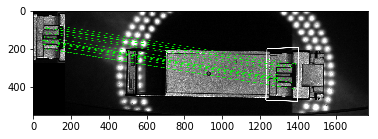

/tf/算法组/SamplePic/CCD22020-5-26_16-10-28.png


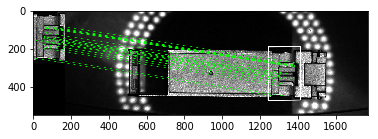

/tf/算法组/SamplePic/CCD22020-5-26_16-10-26.png


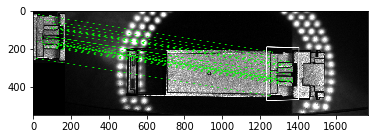

/tf/算法组/SamplePic/CCD22020-5-26_16-10-33.png


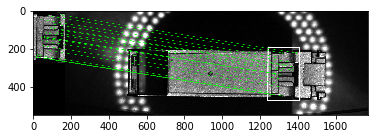

/tf/算法组/SamplePic/CCD22020-5-26_16-10-18.png


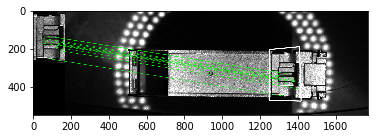

/tf/算法组/SamplePic/CCD22020-5-26_16-10-30.png


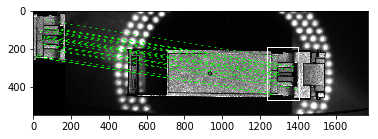

/tf/算法组/SamplePic/CCD22020-5-26_16-10-34.png


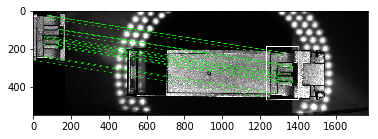

/tf/算法组/SamplePic/CCD22020-5-26_16-10-21.png


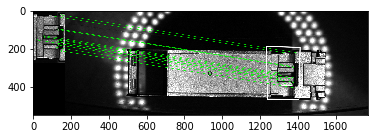

/tf/算法组/SamplePic/CCD22020-5-26_16-10-20.png


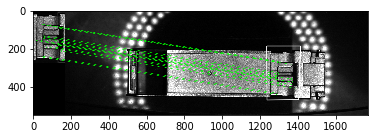

/tf/算法组/SamplePic/CCD22020-5-26_16-10-23.png


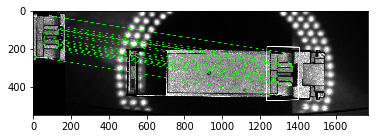

In [107]:
MIN_MATCH_COUNT = 10
save_path = "/tf/算法组/SamplePic/results"
img1 = cv2.imread('right.png',0)
for filename in glob.glob("/tf/算法组/SamplePic/*.png"):
    print(filename)
    img2 = cv2.imread(filename,0)
    
    # 使用SIFT检测角点
    sift = cv2.xfeatures2d.SIFT_create()
    #sift=cv2.SIFT()

    # 获取关键点和描述符
    kp1, des1 = sift.detectAndCompute(img1,None)
    kp2, des2 = sift.detectAndCompute(img2,None)

    # 定义FLANN匹配器
    index_params = dict(algorithm = 1, trees = 5)
    search_params = dict(checks = 50)
    flann = cv2.FlannBasedMatcher(index_params, search_params)
    # 使用KNN算法匹配
    matches = flann.knnMatch(des1,des2,k=2)

    # 去除错误匹配
    good = []
    for m,n in matches:
        if m.distance < 0.7*n.distance:
            good.append(m)


    # 单应性
    if len(good)>MIN_MATCH_COUNT:
        # 改变数组的表现形式，不改变数据内容，数据内容是每个关键点的坐标位置
        src_pts = np.float32([ kp1[m.queryIdx].pt for m in good ]).reshape(-1,1,2)
        dst_pts = np.float32([ kp2[m.trainIdx].pt for m in good ]).reshape(-1,1,2)
        # findHomography 函数是计算变换矩阵
        # 参数cv2.RANSAC是使用RANSAC算法寻找一个最佳单应性矩阵H，即返回值M
        # 返回值：M 为变换矩阵，mask是掩模
        M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC,5.0)
        # ravel方法将数据降维处理，最后并转换成列表格式
        matchesMask = mask.ravel().tolist()
        # 获取img1的图像尺寸
        h,w = img1.shape
        # pts是图像img1的四个顶点
        pts = np.float32([[0,0],[0,h-1],[w-1,h-1],[w-1,0]]).reshape(-1,1,2)
        # 计算变换后的四个顶点坐标位置
        dst = cv2.perspectiveTransform(pts,M)

        # 根据四个顶点坐标位置在img2图像画出变换后的边框
        img2 = cv2.polylines(img2,[np.int32(dst)],True,(255,0,0),3, cv2.LINE_AA)

    else:
        print("Not enough matches are found - %d/%d") % (len(good),MIN_MATCH_COUNT)
        matchesMask = None

    # 显示匹配结果
    draw_params = dict(matchColor = (0,255,0), # draw matches in green color
                       singlePointColor = None,
                       matchesMask = matchesMask, # draw only inliers
                       flags = 2)
    img3 = cv2.drawMatches(img1,kp1,img2,kp2,good,None,**draw_params)
    
    plt.imshow(img3)
    plt.show()
    # "cv2.imshow" may lead to a Kernel crash so we change it to the 'plt' handle to check the image
    #cv2.imshow("Image show", img3)
    #cv2.waitKey(0)
    cv2.imwrite(os.path.join(save_path, filename+'result.png'), img3)

for result_file in glob.glob("/tf/算法组/SamplePic/*.pngresult.png"): # move the result images to the "results" folder
    shutil.move(result_file,save_path)